# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_3()
model = model.to(config['DEVICE'])
model_name = "cvt_3"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_3 (CvT_3)                                           [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 196, 192]       --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 192, 28, 28]    602,112              True
│    └─MaxPool2d (max_pool)                             [32, 192, 28, 28]    [32, 192, 14, 14]    --                   --
│    └─Flatten (flatten)                                [32, 192, 14, 14]    [32, 192, 196]       --                   --
├─Dropout

# Training

Training: 100%|██████████| 281/281 [01:15<00:00,  3.71it/s]


Epoch 1 | Train Loss: 2.2802395133361273 | Accuracy: 0.13339651039634318 | Precision: 0.12997272048065842 | Recall: 0.13339651039634318 | F1: 0.12070141266450524


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.03936681948917 | Accuracy: 0.22318840579710145 | Precision: 0.2817740277029487 | Recall: 0.22318840579710145 | F1: 0.16535032272562206
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 2 | Train Loss: 1.7427694742365665 | Accuracy: 0.35882713640671166 | Precision: 0.35046418430011556 | Recall: 0.35882713640671166 | F1: 0.3488264248183209


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


	Validation Loss: 1.355789046891978 | Accuracy: 0.5079152731326645 | Precision: 0.5235399978164232 | Recall: 0.5079152731326645 | F1: 0.47516194848600785
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.59it/s]


Epoch 3 | Train Loss: 1.235639914711175 | Accuracy: 0.5557723395952952 | Precision: 0.5472679802052156 | Recall: 0.5557723395952952 | F1: 0.5481285259103398


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


	Validation Loss: 0.9949416090065325 | Accuracy: 0.6494983277591974 | Precision: 0.7021025471026453 | Recall: 0.6494983277591974 | F1: 0.6363931802854553
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.59it/s]


Epoch 4 | Train Loss: 0.8928500392683036 | Accuracy: 0.6938513852500139 | Precision: 0.6881906742203758 | Recall: 0.6938513852500139 | F1: 0.6892757556186374


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.77it/s]


	Validation Loss: 0.675424853680839 | Accuracy: 0.7663322185061315 | Precision: 0.8080291962081091 | Recall: 0.7663322185061315 | F1: 0.7621386827131696
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.61it/s]


Epoch 5 | Train Loss: 0.6385293294314388 | Accuracy: 0.7898991025140755 | Precision: 0.7864609735991054 | Recall: 0.7898991025140755 | F1: 0.7869232981077872


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.28it/s]


	Validation Loss: 0.4083445836120928 | Accuracy: 0.8680044593088071 | Precision: 0.8692675400041608 | Recall: 0.8680044593088071 | F1: 0.8658386759762086
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 6 | Train Loss: 0.4688986179243203 | Accuracy: 0.8492112157868331 | Precision: 0.8475700484966998 | Recall: 0.8492112157868331 | F1: 0.8477352804654827


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 0.35387196066513865 | Accuracy: 0.882943143812709 | Precision: 0.8950849659071815 | Recall: 0.882943143812709 | F1: 0.8796709803021014
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.67it/s]


Epoch 7 | Train Loss: 0.38915376280338315 | Accuracy: 0.8761357935224929 | Precision: 0.8752847050762201 | Recall: 0.8761357935224929 | F1: 0.8752921929515957


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.64it/s]


	Validation Loss: 0.33470428535636043 | Accuracy: 0.8929765886287625 | Precision: 0.8981422506177219 | Recall: 0.8929765886287625 | F1: 0.8923669190280378
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.66it/s]


Epoch 8 | Train Loss: 0.3163370851201943 | Accuracy: 0.9008863370310497 | Precision: 0.9004879538303358 | Recall: 0.9008863370310497 | F1: 0.9004911302962275


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


	Validation Loss: 0.21462901261910586 | Accuracy: 0.9369007803790412 | Precision: 0.9386752025657255 | Recall: 0.9369007803790412 | F1: 0.9361319825117823
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.63it/s]


Epoch 9 | Train Loss: 0.27496470131801964 | Accuracy: 0.9135403311221362 | Precision: 0.9132801407944433 | Recall: 0.9135403311221362 | F1: 0.913311412723318


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.25664156769782726 | Accuracy: 0.9137123745819398 | Precision: 0.9249790128882917 | Recall: 0.9137123745819398 | F1: 0.9099957409017789


Training: 100%|██████████| 281/281 [01:19<00:00,  3.55it/s]


Epoch 10 | Train Loss: 0.24039656573449164 | Accuracy: 0.9241875243882045 | Precision: 0.9239017984388884 | Recall: 0.9241875243882045 | F1: 0.9239401547709039


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.1705296632479614 | Accuracy: 0.945819397993311 | Precision: 0.9518369191591074 | Recall: 0.945819397993311 | F1: 0.9456018426556094
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 11 | Train Loss: 0.2106467002333271 | Accuracy: 0.9355593957299738 | Precision: 0.9353026608905085 | Recall: 0.9355593957299738 | F1: 0.9353570889428762


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


	Validation Loss: 0.15906748243830574 | Accuracy: 0.9540691192865106 | Precision: 0.955065798696954 | Recall: 0.9540691192865106 | F1: 0.9539854512769081
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.61it/s]


Epoch 12 | Train Loss: 0.19706157814989736 | Accuracy: 0.9372874742181838 | Precision: 0.9371498365023316 | Recall: 0.9372874742181838 | F1: 0.9371907791504969


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.12653561870396976 | Accuracy: 0.9663322185061316 | Precision: 0.9665962043450347 | Recall: 0.9663322185061316 | F1: 0.9662372251735649
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.65it/s]


Epoch 13 | Train Loss: 0.1774330257149778 | Accuracy: 0.9452031885835331 | Precision: 0.9450490154453564 | Recall: 0.9452031885835331 | F1: 0.9450747531063287


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


	Validation Loss: 0.12910139306225407 | Accuracy: 0.9678929765886287 | Precision: 0.9686028378819328 | Recall: 0.9678929765886287 | F1: 0.9680005314357585


Training: 100%|██████████| 281/281 [01:16<00:00,  3.67it/s]


Epoch 14 | Train Loss: 0.16617578742661085 | Accuracy: 0.9462623334634037 | Precision: 0.9462065883363343 | Recall: 0.9462623334634037 | F1: 0.9461915485079236


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.44it/s]


	Validation Loss: 0.13880076828661939 | Accuracy: 0.9571906354515051 | Precision: 0.9600624162418941 | Recall: 0.9571906354515051 | F1: 0.9569466649800697


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 15 | Train Loss: 0.15226785523744027 | Accuracy: 0.9513350799933107 | Precision: 0.9513167991196193 | Recall: 0.9513350799933107 | F1: 0.9513047491353429


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.1571995415003367 | Accuracy: 0.9480490523968785 | Precision: 0.9527822667125069 | Recall: 0.9480490523968785 | F1: 0.9469111720820383


Training: 100%|██████████| 281/281 [01:17<00:00,  3.64it/s]


Epoch 16 | Train Loss: 0.15077696674340985 | Accuracy: 0.9537878365572217 | Precision: 0.9537626547158238 | Recall: 0.9537878365572217 | F1: 0.9537475202701834


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.66it/s]


	Validation Loss: 0.13607349873743427 | Accuracy: 0.9587513935340022 | Precision: 0.9629160483466179 | Recall: 0.9587513935340022 | F1: 0.9594407201046952


Training: 100%|██████████| 281/281 [01:18<00:00,  3.59it/s]


Epoch 17 | Train Loss: 0.12088049767916736 | Accuracy: 0.9621495066614638 | Precision: 0.9621140270171098 | Recall: 0.9621495066614638 | F1: 0.9621112598709197


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


	Validation Loss: 0.10234703580048722 | Accuracy: 0.9692307692307692 | Precision: 0.9693599811296366 | Recall: 0.9692307692307692 | F1: 0.9690863968382958
Saving best model at epoch 17...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.57it/s]


Epoch 18 | Train Loss: 0.12527387868281573 | Accuracy: 0.9607001505100619 | Precision: 0.9606407239315309 | Recall: 0.9607001505100619 | F1: 0.9606409612256424


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


	Validation Loss: 0.09754251922205301 | Accuracy: 0.9723522853957637 | Precision: 0.9725504833475374 | Recall: 0.9723522853957637 | F1: 0.9723425193203775
Saving best model at epoch 18...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 19 | Train Loss: 0.11407760766689463 | Accuracy: 0.9643792853559284 | Precision: 0.9643911425401862 | Recall: 0.9643792853559284 | F1: 0.9643713581085761


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.09584818920776458 | Accuracy: 0.9732441471571907 | Precision: 0.9737377693867361 | Recall: 0.9732441471571907 | F1: 0.973141267091639
Saving best model at epoch 19...


Training: 100%|██████████| 281/281 [01:15<00:00,  3.73it/s]


Epoch 20 | Train Loss: 0.10194937305133855 | Accuracy: 0.9681699091365182 | Precision: 0.9681415703997973 | Recall: 0.9681699091365182 | F1: 0.968147540318614


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


	Validation Loss: 0.10567105202083017 | Accuracy: 0.968561872909699 | Precision: 0.9711004254170045 | Recall: 0.968561872909699 | F1: 0.9688141616197486


Training: 100%|██████████| 281/281 [01:15<00:00,  3.70it/s]


Epoch 21 | Train Loss: 0.10447117520555907 | Accuracy: 0.9681141646691566 | Precision: 0.9680909165380782 | Recall: 0.9681141646691566 | F1: 0.9680845016754082


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


	Validation Loss: 0.08817345482415297 | Accuracy: 0.974581939799331 | Precision: 0.975350939394238 | Recall: 0.974581939799331 | F1: 0.9745918379059173
Saving best model at epoch 21...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.55it/s]


Epoch 22 | Train Loss: 0.09548844831243317 | Accuracy: 0.9692847984837505 | Precision: 0.9692525665655884 | Recall: 0.9692847984837505 | F1: 0.9692551079445646


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


	Validation Loss: 0.11506801371423292 | Accuracy: 0.9656633221850613 | Precision: 0.9669818153852878 | Recall: 0.9656633221850613 | F1: 0.9652062842813306


Training: 100%|██████████| 281/281 [01:14<00:00,  3.75it/s]


Epoch 23 | Train Loss: 0.09025651355045333 | Accuracy: 0.9706226657004292 | Precision: 0.9706239889902805 | Recall: 0.9706226657004292 | F1: 0.9706137977696141


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 0.06930213497007187 | Accuracy: 0.9794871794871794 | Precision: 0.979657905369704 | Recall: 0.9794871794871794 | F1: 0.9794985654494146
Saving best model at epoch 23...


Training: 100%|██████████| 281/281 [01:15<00:00,  3.73it/s]


Epoch 24 | Train Loss: 0.09105892114182172 | Accuracy: 0.9716818105802999 | Precision: 0.9716600487974778 | Recall: 0.9716818105802999 | F1: 0.9716612534971845


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.69it/s]


	Validation Loss: 0.0794793710007634 | Accuracy: 0.9772575250836121 | Precision: 0.9773263234058224 | Recall: 0.9772575250836121 | F1: 0.9772020743545661


Training: 100%|██████████| 281/281 [01:15<00:00,  3.72it/s]


Epoch 25 | Train Loss: 0.08982164978656215 | Accuracy: 0.9716260661129383 | Precision: 0.9716355214777448 | Recall: 0.9716260661129383 | F1: 0.9716262501801235


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


	Validation Loss: 0.06320285823353579 | Accuracy: 0.9812709030100334 | Precision: 0.9813320994878111 | Recall: 0.9812709030100334 | F1: 0.9812710409365891
Saving best model at epoch 25...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.70it/s]


Epoch 26 | Train Loss: 0.07748699582304501 | Accuracy: 0.974859245219912 | Precision: 0.9748567605836161 | Recall: 0.974859245219912 | F1: 0.9748469521641746


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 0.08562169810363525 | Accuracy: 0.9772575250836121 | Precision: 0.9782324645561165 | Recall: 0.9772575250836121 | F1: 0.9773109460737004


Training: 100%|██████████| 281/281 [01:15<00:00,  3.73it/s]


Epoch 27 | Train Loss: 0.07977362549151178 | Accuracy: 0.9756954122303362 | Precision: 0.9757007760674619 | Recall: 0.9756954122303362 | F1: 0.9756929462545418


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.07780779153764458 | Accuracy: 0.9772575250836121 | Precision: 0.9775794856417968 | Recall: 0.9772575250836121 | F1: 0.9771942322118655


Training: 100%|██████████| 281/281 [01:19<00:00,  3.56it/s]


Epoch 28 | Train Loss: 0.07428926361055242 | Accuracy: 0.9762528569039522 | Precision: 0.9762467807318038 | Recall: 0.9762528569039522 | F1: 0.9762461467080165


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.86it/s]


	Validation Loss: 0.08156410343682682 | Accuracy: 0.9765886287625418 | Precision: 0.9768681128310227 | Recall: 0.9765886287625418 | F1: 0.9765655566213635


Training: 100%|██████████| 281/281 [01:15<00:00,  3.71it/s]


Epoch 29 | Train Loss: 0.06530887783369135 | Accuracy: 0.9803779474887118 | Precision: 0.9803699595864853 | Recall: 0.9803779474887118 | F1: 0.9803691341717526


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


	Validation Loss: 0.07616353153028119 | Accuracy: 0.9768115942028985 | Precision: 0.9780195296156026 | Recall: 0.9768115942028985 | F1: 0.9769414479732089


Training: 100%|██████████| 281/281 [01:16<00:00,  3.65it/s]


Epoch 30 | Train Loss: 0.06513997447408497 | Accuracy: 0.9792073136741178 | Precision: 0.9792196428037048 | Recall: 0.9792073136741178 | F1: 0.9792099560781321


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.05347695014387054 | Accuracy: 0.9857302118171684 | Precision: 0.9858188586426817 | Recall: 0.9857302118171684 | F1: 0.9857351243391687
Saving best model at epoch 30...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.64it/s]


Epoch 31 | Train Loss: 0.052927754357046185 | Accuracy: 0.9843358046713864 | Precision: 0.9843444546123304 | Recall: 0.9843358046713864 | F1: 0.9843324126759497


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.64it/s]


	Validation Loss: 0.0819971349523206 | Accuracy: 0.9756967670011149 | Precision: 0.9761934682094363 | Recall: 0.9756967670011149 | F1: 0.9757058460363867


Training: 100%|██████████| 281/281 [01:17<00:00,  3.64it/s]


Epoch 32 | Train Loss: 0.06628850448770561 | Accuracy: 0.9783154021963321 | Precision: 0.9783118942962535 | Recall: 0.9783154021963321 | F1: 0.9783076635369706


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.71it/s]


	Validation Loss: 0.06387085286231423 | Accuracy: 0.9819397993311036 | Precision: 0.9826279244978285 | Recall: 0.9819397993311036 | F1: 0.9820897773851863


Training: 100%|██████████| 281/281 [01:17<00:00,  3.62it/s]


Epoch 33 | Train Loss: 0.051591587362287306 | Accuracy: 0.9845587825408328 | Precision: 0.9845520838951629 | Recall: 0.9845587825408328 | F1: 0.9845510083958904


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


	Validation Loss: 0.0492503268572069 | Accuracy: 0.9872909698996656 | Precision: 0.9873679243143981 | Recall: 0.9872909698996656 | F1: 0.9872988142081703
Saving best model at epoch 33...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.64it/s]


Epoch 34 | Train Loss: 0.054975270867029545 | Accuracy: 0.9829979374547076 | Precision: 0.982989743773546 | Recall: 0.9829979374547076 | F1: 0.98299198511777


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.08406730506464209 | Accuracy: 0.9774804905239688 | Precision: 0.9785356202906483 | Recall: 0.9774804905239688 | F1: 0.977558279141107


Training: 100%|██████████| 281/281 [01:16<00:00,  3.70it/s]


Epoch 35 | Train Loss: 0.04683499241884122 | Accuracy: 0.9854506940186186 | Precision: 0.9854456217730969 | Recall: 0.9854506940186186 | F1: 0.9854431144021618


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


	Validation Loss: 0.06329312203058475 | Accuracy: 0.9812709030100334 | Precision: 0.9814820435103853 | Recall: 0.9812709030100334 | F1: 0.9812402352731789


Training: 100%|██████████| 281/281 [01:15<00:00,  3.75it/s]


Epoch 36 | Train Loss: 0.05389219502258873 | Accuracy: 0.9828864485199844 | Precision: 0.9828757161623275 | Recall: 0.9828864485199844 | F1: 0.9828777400016511


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


	Validation Loss: 0.08031509656616499 | Accuracy: 0.9756967670011149 | Precision: 0.977827668862189 | Recall: 0.9756967670011149 | F1: 0.9761357969977802


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 37 | Train Loss: 0.04491070595327964 | Accuracy: 0.9852834606165338 | Precision: 0.9852858420931933 | Recall: 0.9852834606165338 | F1: 0.9852801034316699


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.76it/s]


	Validation Loss: 0.04914207025890199 | Accuracy: 0.9855072463768116 | Precision: 0.9856671336938202 | Recall: 0.9855072463768116 | F1: 0.9855303327401864
Saving best model at epoch 37...


Training: 100%|██████████| 281/281 [01:15<00:00,  3.75it/s]


Epoch 38 | Train Loss: 0.047437452191646044 | Accuracy: 0.9848932493450026 | Precision: 0.9848826621616903 | Recall: 0.9848932493450026 | F1: 0.9848865712553873


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.06425186668680062 | Accuracy: 0.9830546265328874 | Precision: 0.9832351792682755 | Recall: 0.9830546265328874 | F1: 0.9830371040592096


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 39 | Train Loss: 0.03591346779997291 | Accuracy: 0.9889068509950387 | Precision: 0.9889077012341699 | Recall: 0.9889068509950387 | F1: 0.9889056710998293


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.66it/s]


	Validation Loss: 0.049342790652971556 | Accuracy: 0.9863991081382386 | Precision: 0.9865071567358599 | Recall: 0.9863991081382386 | F1: 0.9864251639000691


Training: 100%|██████████| 281/281 [01:17<00:00,  3.65it/s]


Epoch 40 | Train Loss: 0.03820816327211218 | Accuracy: 0.9877919616478065 | Precision: 0.9877940257699821 | Recall: 0.9877919616478065 | F1: 0.9877888943422924


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 0.0560663126582857 | Accuracy: 0.9837235228539576 | Precision: 0.9839331736971204 | Recall: 0.9837235228539576 | F1: 0.9837487176469629


Training: 100%|██████████| 281/281 [01:17<00:00,  3.63it/s]


Epoch 41 | Train Loss: 0.03985766179857981 | Accuracy: 0.9867328167679358 | Precision: 0.9867375035365702 | Recall: 0.9867328167679358 | F1: 0.9867339460887287


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


	Validation Loss: 0.05870754985322415 | Accuracy: 0.9837235228539576 | Precision: 0.9839955611617411 | Recall: 0.9837235228539576 | F1: 0.983739241448042


Training: 100%|██████████| 281/281 [01:17<00:00,  3.63it/s]


Epoch 42 | Train Loss: 0.034357692837943835 | Accuracy: 0.9893528067339317 | Precision: 0.989355793474228 | Recall: 0.9893528067339317 | F1: 0.9893526428112127


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.35it/s]


	Validation Loss: 0.03661657766517724 | Accuracy: 0.9897435897435898 | Precision: 0.9898690882334428 | Recall: 0.9897435897435898 | F1: 0.9897733184236956
Saving best model at epoch 42...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.61it/s]


Epoch 43 | Train Loss: 0.03783005909137494 | Accuracy: 0.9874017503762752 | Precision: 0.9873958921952365 | Recall: 0.9874017503762752 | F1: 0.9873981227253855


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.65it/s]


	Validation Loss: 0.04356033056416929 | Accuracy: 0.9897435897435898 | Precision: 0.9898773321390215 | Recall: 0.9897435897435898 | F1: 0.9897748628400322


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 44 | Train Loss: 0.03327669264513376 | Accuracy: 0.9895200401360165 | Precision: 0.9895255388702544 | Recall: 0.9895200401360165 | F1: 0.9895215995111577


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


	Validation Loss: 0.0634043297113877 | Accuracy: 0.9835005574136009 | Precision: 0.9837558166340289 | Recall: 0.9835005574136009 | F1: 0.9835379695255078


Training: 100%|██████████| 281/281 [01:17<00:00,  3.65it/s]


Epoch 45 | Train Loss: 0.03588177272188229 | Accuracy: 0.9877919616478065 | Precision: 0.987796759134197 | Recall: 0.9877919616478065 | F1: 0.9877924691891138


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.59it/s]


	Validation Loss: 0.0542835365049541 | Accuracy: 0.9859531772575251 | Precision: 0.9860669223541421 | Recall: 0.9859531772575251 | F1: 0.9859665468012503


Training: 100%|██████████| 281/281 [01:15<00:00,  3.75it/s]


Epoch 46 | Train Loss: 0.029475610805559386 | Accuracy: 0.9901332292769942 | Precision: 0.9901373189143016 | Recall: 0.9901332292769942 | F1: 0.9901344009144518


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.07695209132638615 | Accuracy: 0.9803790412486064 | Precision: 0.9813407389852432 | Recall: 0.9803790412486064 | F1: 0.9803897190656254


Training: 100%|██████████| 281/281 [01:16<00:00,  3.66it/s]


Epoch 47 | Train Loss: 0.030734876529529054 | Accuracy: 0.9899659958749094 | Precision: 0.9899621541521136 | Recall: 0.9899659958749094 | F1: 0.9899609808206725


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


	Validation Loss: 0.04771159020003299 | Accuracy: 0.9899665551839465 | Precision: 0.9901648720022939 | Recall: 0.9899665551839465 | F1: 0.9899990172007209


Training: 100%|██████████| 281/281 [01:16<00:00,  3.66it/s]


Epoch 48 | Train Loss: 0.026386759222155352 | Accuracy: 0.9914153520263114 | Precision: 0.9914086425462827 | Recall: 0.9914153520263114 | F1: 0.9914099288715787


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.041491383603039445 | Accuracy: 0.9897435897435898 | Precision: 0.9897879851985808 | Recall: 0.9897435897435898 | F1: 0.9897459178090167


Training: 100%|██████████| 281/281 [01:16<00:00,  3.65it/s]


Epoch 49 | Train Loss: 0.02207098116400549 | Accuracy: 0.9930876860471598 | Precision: 0.9930867958913044 | Recall: 0.9930876860471598 | F1: 0.9930867329964395


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


	Validation Loss: 0.038251111296195746 | Accuracy: 0.9906354515050168 | Precision: 0.990676529768557 | Recall: 0.9906354515050168 | F1: 0.9906328398738082
Early stopping at epoch 49
Training finished!


({'Loss': [2.2802395133361273,
   1.7427694742365665,
   1.235639914711175,
   0.8928500392683036,
   0.6385293294314388,
   0.4688986179243203,
   0.38915376280338315,
   0.3163370851201943,
   0.27496470131801964,
   0.24039656573449164,
   0.2106467002333271,
   0.19706157814989736,
   0.1774330257149778,
   0.16617578742661085,
   0.15226785523744027,
   0.15077696674340985,
   0.12088049767916736,
   0.12527387868281573,
   0.11407760766689463,
   0.10194937305133855,
   0.10447117520555907,
   0.09548844831243317,
   0.09025651355045333,
   0.09105892114182172,
   0.08982164978656215,
   0.07748699582304501,
   0.07977362549151178,
   0.07428926361055242,
   0.06530887783369135,
   0.06513997447408497,
   0.052927754357046185,
   0.06628850448770561,
   0.051591587362287306,
   0.054975270867029545,
   0.04683499241884122,
   0.05389219502258873,
   0.04491070595327964,
   0.047437452191646044,
   0.03591346779997291,
   0.03820816327211218,
   0.03985766179857981,
   0.034357692

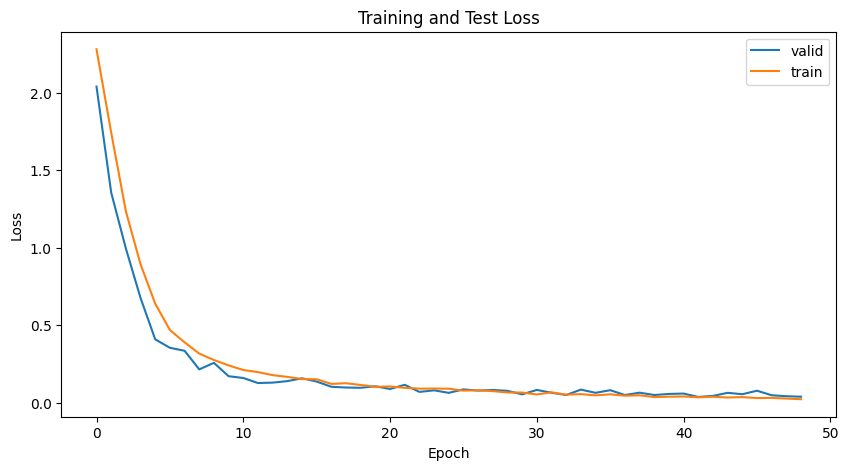

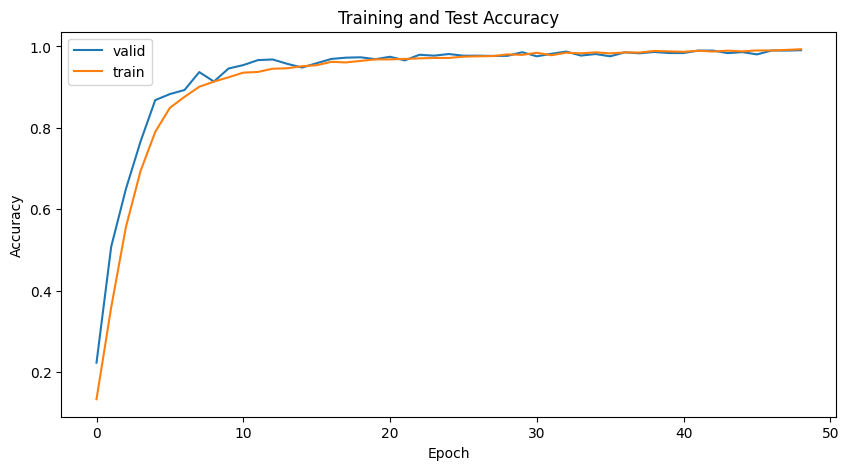

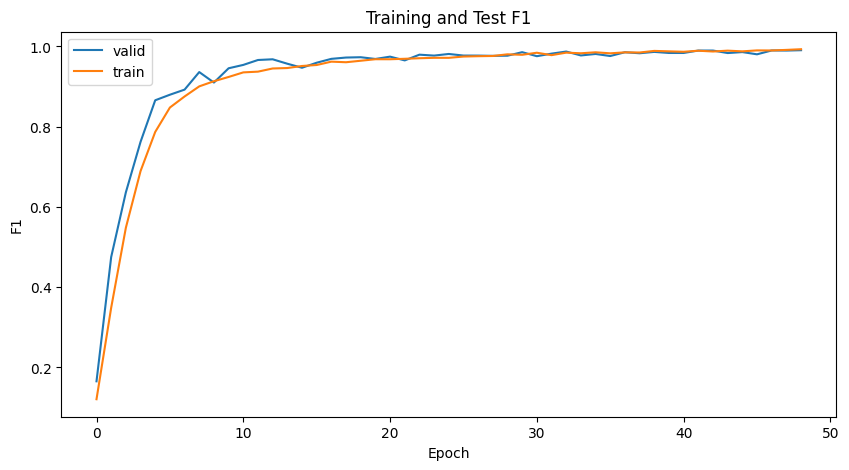

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [03:14<00:00,  6.40it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)